# Profile plotting

This notebook will be to plot variables from an ATL09 file, by profile. This is for comparrison of the data taken at the same time but separated in space.

In [15]:
# initial imports
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

In [16]:
# get the files to be loaded in
loadDir = '/home/users/eeasm/ICESAT_data/RGT0749_Cycles_10-12-bigger'
# extract all the possible .h5 files in the loadDir folder
filenames = [f for f in os.listdir(loadDir) if '.h5' in f]

print('Available files are: ', filenames)

# simply extract the first filename here. Other files can be extracted with different indices.
filename = [loadDir + '/' + f for f in filenames][2]
print(f'Selected filename is {filename}')

Available files are:  ['processed_ATL09_20210211004659_07491001_005_01.h5', 'processed_ATL09_20210512202651_07491101_005_01.h5', 'processed_ATL09_20210811160643_07491201_005_01.h5']
Selected filename is /home/users/eeasm/ICESAT_data/RGT0749_Cycles_10-12-bigger/processed_ATL09_20210811160643_07491201_005_01.h5


In [17]:
f = h5py.File(filename,'r')

In [18]:
# functions used for custom plotting routines
#del f_plot, f_plotT, f_imshow, f_imshowlog


def f_plot(ax,data): 
    return ax.plot(data)

def f_plotT(ax,data):
    return ax.plot(data.T)

def f_imshow(ax, data):
    # use imshow as it runs faster and gives the true pixel values
    return ax.imshow(data.T,aspect='auto')

def f_imshowlog(axs, data,logLimits=[-6,1]): 
    invalidIdx = data <= 0
    data[~invalidIdx] = np.log(data[~invalidIdx])

    # used for capping data if it is (por ejemplo) unreasonably close to 0.
    data[data < logLimits[0]] = logLimits[0]
    data[data > logLimits[1]] = logLimits[1]
    data[invalidIdx] = logLimits[0] - 1
    return f_imshow(axs,data)

def plot_clouds(ax,data):
    data = data[data > 0]
    return f_plot(ax,data)

def f_imshowlog_highlimits(axs,data): return f_imshowlog(axs,data, logLimits=[32,38])

In [22]:
# determine what variables are to be plotted.

# the profiles variable can be iterated through to extract data from each profile
profiles = ['profile_1', 'profile_2', 'profile_3']
numProfs = len(profiles)

variablesDict = {'high_rate': ['cab_prof', 'density_pass2', 'layer_top','sig_h_sdev_hi'],
                'low_rate': ['met_tqi','met_t10m']}
functionsDict = {'high_rate': [f_imshowlog, f_imshowlog_highlimits, f_plot, f_plot],
                'low_rate': [f_plot, f_plot]}

numVars = 0
for k in variablesDict.keys():
    numVars += len(variablesDict[k])

print(numVars)

6


cab_prof: min -7.0; max -4.804720878601074
density_pass2: min 31.0; max 38.0
layer_top: min -1.0; max 10316.703125
sig_h_sdev_hi: min -1.0; max 43.16139602661133
met_tqi: min 1.9915987650165334e-06; max 0.004668372217565775
met_t10m: min 263.3487854003906; max 286.18975830078125


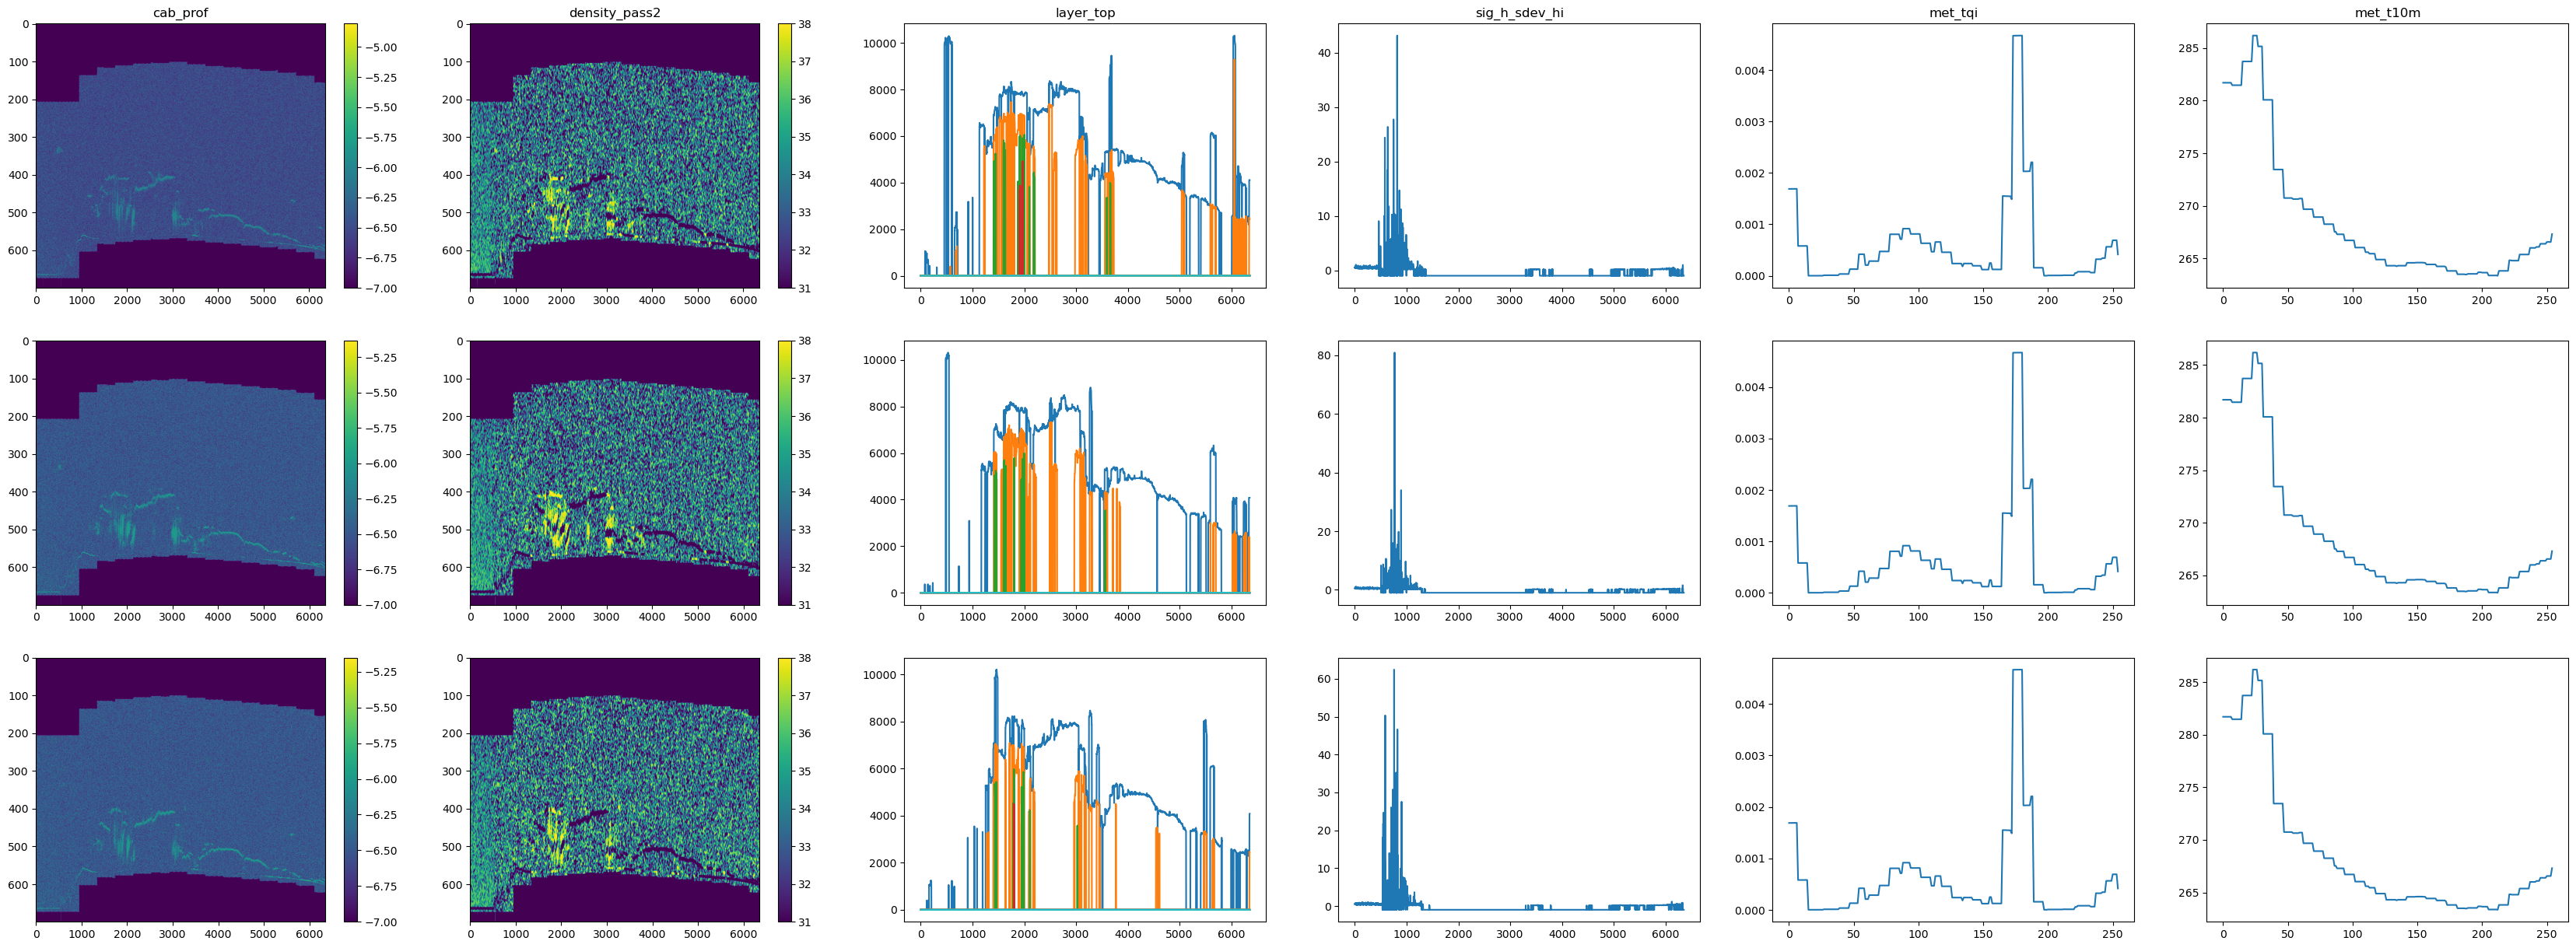

In [23]:
widthPerVar = 7
heightPerVar = 5
fsize = (numVars*widthPerVar, numProfs*heightPerVar)

nanVal = 1e38
errorVal = -1

fig, axs = plt.subplots(numProfs,numVars, figsize=fsize)
for i,p in enumerate(profiles):
    profile = f[p]
    col = 0
    for k in variablesDict.keys():
        for l,dataname in enumerate(variablesDict[k]):
            # extract the variable to be plotted.
            plotData = profile[k][dataname][()]
            
            # remove nan values and set them to errorVal
            #plotData[np.logical_or(np.isnan(plotData), plotData > nanVal)] = errorVal
            plotData[np.isnan(plotData)] = errorVal
            plotData[plotData > nanVal] = errorVal
            
            plottedObj = functionsDict[k][l](axs[i,col], plotData)
            
            # on the top row, add information.
            if i == 0:
                print(f'{dataname}: min {np.min(plotData)}; max {np.max(plotData)}')
                axs[i,col].set_title(dataname)
            if functionsDict[k][l].__name__ in ['f_imshow', 'f_imshowlog','f_imshowlog_highlimits']:
                fig.colorbar(plottedObj,ax=axs[i,col])
            col += 1

plt.show()

In [24]:
#fig.savefig('SummitPassProfile1.png')